# Initial Imports & Setup

Use Python Data Analysis Libraries

In [1]:
# Data Science Modules
import numpy as np
import pandas as pd
import altair as alt
from selenium import webdriver

# Python Basics
import glob as glob
import shutil
import os
import datetime as datetime

# Importing Data into Dataframe

Create pandas dataframe from folder of CSV files.

Maps columns to friendlier names and data for faceting.

Assumes:

* **./files/names.csv**: CSV File with Provider/Clinic Names, etc. Names is used to determine active providers/clinics. (So if there's no name, it wont get evaluated later -- say, for example, after Everson Closes.
* **./files/metrics.csv**: CSV File with Metrics information (Display Name, Category, Target, etc.)
* **./data/(Zero-Padded Date at beginning of CSVs from Meridos).csv**: Files from Automatic weekly report from Meridios

In [2]:
# Read Lookup files into dataframes for mapping
names = pd.read_csv('./files/names.csv', index_col='MeridiosName')
metrics = pd.read_csv('./files/metrics.csv', index_col='MeridiosMetric', dtype={'MeridiosMetric':object})

# Blank dataframe for eventual output.
df = pd.DataFrame()

# Read in all the data files and append to dataframe
files = glob.glob('./data/*.csv')
for file in files:
    filedf = pd.read_csv(file,
                        usecols=["NAME","Metricname","SeenNum","SeenDenom"])
    # Prettier Names but we'll drop these eventually.
    filedf = filedf.rename(columns={'NAME': 'MeridiosName',
                                    'Metricname': 'MeridiosMetric',
                                    'SeenNum': 'Numerator', 
                                    'SeenDenom': 'Denominator'})

    # Add Lookup Columns.
    filedf['Name'] = filedf.MeridiosName.map(names.Name)
    filedf['Type'] = filedf.MeridiosName.map(names.Type)
    filedf['Clinic'] = filedf.MeridiosName.map(names.Clinic)
    filedf['Metric'] = filedf.MeridiosMetric.map(metrics.Metric)
    
    # Who are we kidding with precision? Round to Basis points
    # Not actually percentage (but rather than * 100 leaving for formatting
    # in visualization.)
    filedf['Percentage'] = round(filedf['Numerator'] / filedf['Denominator'], 4)

    # Zero Padded Dates with Dots. Like: "03.15.2018" We're using the filename
    # as the source of the date column because exports haven't always 
    # had the date-time data correct. 
    filename_parts = file[7:-4].split(' ')
    if (len(str(filename_parts[0])) is 10):
        filedf['Date'] = datetime.datetime.strptime(filename_parts[0], "%m.%d.%Y")

        # Now delete the 'raw' columns from import
        filedf.drop("MeridiosName", axis=1, inplace=True)
        filedf.drop("MeridiosMetric", axis=1, inplace=True)
        filedf.drop("Numerator", axis=1, inplace=True)
        filedf.drop("Denominator", axis=1, inplace=True)
        
        # We're only appending data that had Zero Padded Date at 
        # beginning of filename.
        df = df.append(filedf) 
    else:
        print("CSV Data File doesn't have Zero-Padded Date at beginning.")
        
# We can inspect dataframe different ways        
#df.dtypes
#df.info()
#df.describe()
#df.columns
df.Metric.unique()
#df.head()
#metrics.head()

array(['AAA', nan, 'Chlamydia', 'Colorectal Screen', 'DM Care Gaps',
       'DM with Statin', 'DM with ACE or ARB', 'DM Eye Exam',
       'DM Foot Exam', 'HTN Age18 to 59 under 140 SBP',
       'HTN over age 18 under 140 SBP', 'HTN over age 59 under 150 SBP',
       'Mammogram', 'DM Nephropathy', 'Pap Smears', 'DM Pneumovax',
       'Over age 65 Pneumovax', 'Smoker Pneumovax', 'Smoking Cessation',
       'Statin with LDL', 'TD and TDAP', 'WCC 3y to 6y'], dtype=object)

## Validations:

* Do new CSV files include new MeridiosName, New Metric items? (Has the underlying report changed? Such as when edited provider name.)
* Should we keep a list of already imported data and do some message to clarify after new data is available?
* Percentages under 0% and over 100% are report errors

Currently no validations. But probably should automate checks that new data from report is accurate. 

# Altair Graphs

In [5]:
def core_clinic_charts(metric, type, name, clinic): 
    # Shows Individual Providers, a single metric, grouped by a clinic.
    chart = alt.Chart(df[(df['Metric']==metric) & 
                         (df['Type']==type) &
                         (df['Name']==name) & 
                         (df['Clinic']==clinic)]
    ).mark_line(
    ).encode(
        alt.X('Date:T', title=""),
        alt.Y('Percentage:Q', axis=alt.Axis(format="%")),
        color=alt.Color('Name:N'),
        tooltip='Name:N',
    ).properties(
        title=str(metric) + ' at ' + str(clinic),
    ).facet(
        column="Clinic:N",
    )
    return chart

In [5]:
#clinic = 'NCFP'
#type = 'Individual'
#name = 'NCFP'
#for clinic in df.Clinic.unique():
#for metric in df.Metric.unique():
#    chart = core_clinic_charts(metric, type, name, clinic) 
#    foldername = str(name).replace(" ", "_")
#    if not os.path.exists("./altair-output/" + foldername):
#        os.makedirs("./altair-output/" + foldername)
#    chart.save("./altair-output/" + foldername + '/'+ str(metric).replace(" ", "_") + ".json")

In [8]:
metric = 'AAA'
type = 'Individual'
name = 'Jonathan Ploudre'
clinic = 'NCFP'
newdf = df[(df['Metric']==metric) & 
                         (df['Type']==type) &
                         (df['Name']==name) & 
                         (df['Clinic']==clinic)]

newdf

,Name,Type,Clinic,Metric,Percentage,Date
1586,Jonathan Ploudre,Individual,NCFP,AAA,0.2366,2018-04-23
1558,Jonathan Ploudre,Individual,NCFP,AAA,0.2128,2018-01-29
1651,Jonathan Ploudre,Individual,NCFP,AAA,0.1875,2017-12-18
1584,Jonathan Ploudre,Individual,NCFP,AAA,0.2128,2018-03-19
1586,Jonathan Ploudre,Individual,NCFP,AAA,0.2258,2018-04-02
1499,Jonathan Ploudre,Individual,NCFP,AAA,0.1720,2017-10-09
1628,Jonathan Ploudre,Individual,NCFP,AAA,0.2128,2018-02-19
1674,Jonathan Ploudre,Individual,NCFP,AAA,0.1915,2018-01-08
1581,Jonathan Ploudre,Individual,NCFP,AAA,0.2083,2018-01-22
1701,Jonathan Ploudre,Individual,NCFP,AAA,0.1739,2017-10-23


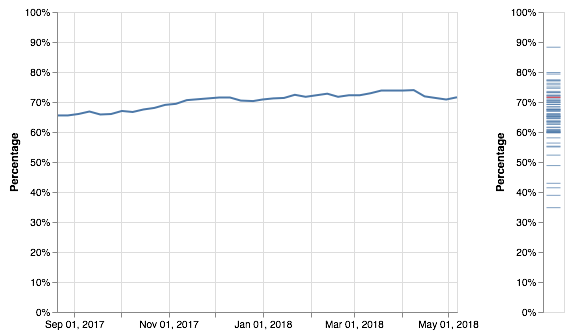

In [25]:
metric = 'Mammogram'
type = 'Individual'
name = 'Jonathan Ploudre'

current_date = max(df['Date'])
current_metric = df[(df['Metric']==metric) & 
                         (df['Type']==type) &
                   (df['Date']==current_date)]

fcn_current_strip_chart = alt.Chart(current_metric
    ).mark_tick(
    ).encode(
        alt.Y('Percentage:Q', axis=alt.Axis(format="%")),
    )

provider_highlight_strip = alt.Chart(current_metric
    ).mark_tick(
    color='red',
    ).transform_filter(
    alt.FieldEqualPredicate(field='Name', equal=name)
    ).encode(
        alt.Y('Percentage:Q', 
              axis=alt.Axis(format="%"),
              scale=alt.Scale(domain=(0, 1))),
    )

progress_line = alt.Chart(df[(df['Metric']==metric) & 
                         (df['Type']==type) &
                         (df['Name']==name)]
    ).mark_line(
    ).encode(
        alt.X('Date:T', title=""),
        alt.Y('Percentage:Q', axis=alt.Axis(format="%"), 
              scale=alt.Scale(domain=(0, 1))),
    )

progress_line | (fcn_current_strip_chart + provider_highlight_strip)